# Introduction

Scholar is a framework for document modeling, much like LDA, but with the ability to flexibly incorporate metadata, with some similarity to the structural topic model. It can scale to large numbers of covariates, runs in python, and offers GPU support for fast exploration of a corpus of documents.

In this tutorial, we'll use a toy corpus of political press releases in order to demonstrate the functionality and interface of Scholar.

# Setup

### Code

If you're looking at this tutorial, you have presumably already downloaded/cloned the Scholar repo. If not, you can clone it using: 

`git clone git@github.com:dallascard/scholar.git`

(if you don't have git set up, you can just download the repo from https://github.com/dallascard/scholar)

Scholar has not yet been packaged us as a full python packge. As such, we will just run commands from the scholar directory, so switch into it:

`cd /path/to/scholar`

(the directory that contains this notebook)

### Environment

Create new python environment for running scholar. We recommend using Anaconda, but it is also possible to do this using virtualenv and pip. Assuming you are using conda, run the following three commands, one at a time, and follow the prompts:

`conda create -n scholar python=3`

`source activate scholar`

`conda install ipython notebook numpy scipy pandas matplotlib gensim pytorch torchvision -c pytorch`

You should also now quit this notebook and reload it from with the scholar environment (i.e. after running `source activate scholar` in the shell).

### Data

For this tutorial, we'll be using a subset of the Congressional press release corpus created by Justin Grimmer.

A compressed file with press releases from six senators can be found in this repo. To expand it, run

`tar -xzf tutorial.tar.gz`

which will create a  directory called  `tutorial/CongressPressExpand/`

For those who are interested, the full dataset (Press.tar; 282Mb) can be downloaded from https://dataverse.harvard.edu/dataset.xhtml?persistentId=hdl:1902.1/14596

# Data Import

To use scholar, it is necessary to get the data into the proper format. To do this, the easiest thing to do is to write a script to convert the documents into a single file, where each line corresponds to one document, represented as a JSON object. Each JSON object should have at least one field called "text", but it can also contain other metadata fields.

We have included a script to convert a subset of the Senatorial press releases into this format, which can be used as a starting point for your own project.

If running this from the command line, it would be run as

`python import_congress_press.py tutorial/CongressPressExpand tutorial/congress/`

Since we are running this in a notebook, we will run it by importing the package, and calling the `main()` function with the corresponding arguments in a list.

In [67]:
import import_congress_press
script = 'import_congress_press'
args = 'tutorial/CongressPressExpand tutorial/congress'
print("python", script, args)
import_congress_press.main(args.split())

python import_congress_press tutorial/CongressPressExpand tutorial/congress
274 files from Sanders
709 files from Obama
358 files from Klobuchar
293 files from McCain
614 files from Graham
235 files from Coburn
Saving files to tutorial/congress
Done!


This creates two files in the output directory (`/tutorial/congress/`):
- `train.jsonlist` contains one press release per line, in JSON format, including fields for the text of the press release, as well as senator name, party, date, year, and month
- `train.score.csv` contains DW-nominate scores for 6 senators from the 110th congress, with one score for each document in `train.jsonlist` (in the same order).

To inspect a document, we can use the `json` library to load it

In [68]:
import os
import json
with open(os.path.join('tutorial', 'congress', 'train.jsonlist')) as f:
    lines = f.readlines()
first_doc = json.loads(lines[0])
for key, value in first_doc.items():
    print(key, ':', value)

id : 10Apr2007Sanders238.txt
text : SEIZE THE OPPORTUNITY FOR MAJOR BREAKTHROUGHS IN HEALTH CARE   The Senate this week is considering a bill, cosponsored by Sen. Bernie Sanders, that would expand and encourage federal funding of human embryonic stem cell research. President Bush in 2001 cut off federal funding for research involving new embryonic stem cells, which has dramatically stalled this critical area of medical research.      "My hope is that, as a result of increased pressure from scientists, physicians and the American people, the president will change his position or, if he does not, that the Congress will have enough votes to override his veto and establish unrestricted federal funding for stem cell research," Sanders said. "The potential is now available for major breakthroughs in Parkinson's disease, Alzheimer's, diabetes, spinal cord injury, stroke, heart disease and many other illnesses. We must seize the opportunity."     View a copy of the Bill - S. 5 at http://sander

If we had documents that we wanted to use as a test set, we could create a `test.jsonlist` object in the same manner.

# Preprocessing

The next step is to use a preprocessing script we have provided to convert the documents from JSON format into a numerical representation. It works by creating a vocabulary, filtering out numbers, punctuation, and some other tokens, and saving the document-term count matrix. 

The preprocessing script can also simultaneously pull out various metadata attributes (like author or year) from the JSON objects, and convert them into one-hot representations, which will be saved as .csv files.

For other types of metadata, such as continously-valued data, you will need to create the corresponding .csv files manually, as we did above for `train.score.csv`. All that matters is that the order of the rows is the same as the the order of documents in `train.jsonlist`. Also, scholar will expect the file name to be `train.field_name.csv` (or "test" rather than "train" for test data).

To see the full set of options for any command, try running it with the `-h` option. Again, in the shell, this would be run as:

`python preprocess_data.py -h`

In [69]:
import preprocess_data
args = '-h'
print("python preprocess_data.py -h")
preprocess_data.main([args])

python preprocess_data.py -h
Usage: ipykernel_launcher.py train.jsonlist output_dir

Options:
  -h, --help            show this help message and exit
  --label=LABEL         field(s) to use as label (comma-separated):
                        default=none
  --test=TEST           Test data (test.jsonlist): default=none
  --train-prefix=TRAIN_PREFIX
                        Output prefix for training data: default=train
  --test-prefix=TEST_PREFIX
                        Output prefix for test data: default=test
  --stopwords=STOPWORDS
                        List of stopwords to exclude [None|mallet|snowball]:
                        default=snowball
  --min-doc-count=MIN_DOC_COUNT
                        Exclude words that occur in less than this number of
                        documents
  --max-doc-freq=MAX_DOC_FREQ
                        Exclude words that occur in more than this proportion
                        of documents
  --keep-num            Keep tokens made of only numbers

SystemExit: 0

/Users/dcard/anaconda/envs/pytorch4/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2969: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Here, we'll tell it to create a vocabulary of only 1000 words, to help the model run faster. This will select the most common 1000 words, after excluding stopwords in a standard stopword list. We'll also tell it to create the label matrices for the various metadata attributes, which we provide in a comma-separated list (without spaces). As a reminder, it will assume that each of these metadata names will be a field in each JSON document object.

In [70]:
script = 'preprocess_data.py'
args = 'tutorial/congress/train.jsonlist tutorial/congress --vocab-size 1000 --label senator,party,year,month,date'
print("python", script, args)
preprocess_data.main(args.split())

python preprocess_data.py tutorial/congress/train.jsonlist tutorial/congress --vocab-size 1000 --label senator,party,year,month,date
Using snowball stopwords
Reading data files
Found 2483 training documents
Found label senator with 6 classes
Found label party with 2 classes
Found label year with 4 classes
Found label month with 12 classes
Found label date with 918 classes
Parsing 2483 documents
Size of full vocabulary=22131
Selecting the vocabulary
Vocab size after filtering = 22131
Final vocab size = 1000
Most common words remaining: senator washington today said senate contact press also current date
Converting to count representations
Size of train document-term matrix: (2483, 1000)
0 words missing from training data
Done!


This preprocessing script creates several files, some uesd by Scholar, and some designed for other software, like Mallet. The files of interest are:
- `train.npz`, which contains a (D x V) sparse matrix of document word counts,
- `train.vocab.json`, which contains the vocabualry as a JSON object, and;
- files like `train.year.csv`, which contain the year corresponding to each document, in a matrix of size (D x C), where C is the number of distinct covariate values (e.g. years)

Let's look at a couple of files:

In [71]:
# load the vocabualry
with open(os.path.join('tutorial', 'congress', 'train.vocab.json')) as f:
    vocab = json.load(f)
print("First few words in the vocbulary:")
print(vocab[:6] + ['...'])

First few words in the vocbulary:
['ability', 'able', 'abuse', 'access', 'according', 'accountability', '...']


In [72]:
# load a covariate file
import pandas as pd
print("Start of a covariate file (train.year.csv):")
df = pd.read_csv(os.path.join('tutorial', 'congress', 'train.year.csv'), header=0, index_col=0)
print(df.head())

Start of a covariate file (train.year.csv):
                         2005  2006  2007  2008
10Apr2007Sanders238.txt     0     0     1     0
10Apr2008Sanders2.txt       0     0     0     1
10Apr2008Sanders3.txt       0     0     0     1
10Dec2007Sanders61.txt      0     0     1     0
10May2007Sanders212.txt     0     0     1     0


Note that if we had a test corpus, we could simultaneously process it by adding the `--test` option to our call to `preprocess_data` (with the path to `test.jsonlist`).

# Running Scholar

We are now ready to run Scholar!

To start off, let's just run a basic topic model, without any metadata. We just need to specify the input directory,  and it will look for the `train.npz` file, as well as `train.vocab.json`. 

Here, we'll also tell it to use 10 topics (`-k`), tell it only to run for 50 epochs (`--epochs 50`), and to use a random 1/10th of the data as a dev/validation set to monitor the fit (`--dev-folds 10`). 

In [73]:
import run_scholar
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 50 --dev-folds 10 --seed 99'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 50 --dev-folds 10 --seed 99
Loading data
Loaded 2483 documents with 1000 features
Found 2483 non-empty documents
Computing background frequencies
Min/max word counts in training data: 89 5075
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1000
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 0
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Optimizing full model
Epoch: 10 cost= 1115.742679058
Epoch: 10; Dev perplexity = 927.8107
Epoch: 20 cost= 1100.415869250
Epoch: 20; Dev perplexity = 798.8516
Epoch: 30 cost= 1113.968918222
Epoch: 30; Dev perplexity = 734.1056
Epoch: 40 cost= 1098.092338681
Epoch: 40; Dev perplexity = 716.1438
Background frequencies of top words:
senator obama bill said senate today washington graham press president
[0.01305886 0.01280154 0.00948215 0.00868446 0.00810808 0.00686008
 0.00643037 0.00634545 0.006

To display this a bit more cleanly, let's load the output and look at it.

By default, the output of the model is saved to a directory called `output`, but that can be changed using the `-o` option (remember to use `-h` to see all options).

First, let's inspect the background frequencies of the most common words (the log-frequencies are computed and saved)

In [74]:
import json
import numpy as np

# load the background log-frequencies
bg = np.load('output/bg.npz')['bg']

# load the vocabualry
with open('output/vocab.json') as f:
    vocab = json.load(f)

# sort terms by log-frequency
order = np.argsort(bg)

# print the most common words 
for i in range(1, 16):
    index = order[-i]
    print(vocab[index], np.exp(bg[index]))

senator 0.013058862
obama 0.012801543
bill 0.009482149
said 0.008684464
senate 0.008108076
today 0.006860084
washington 0.006430366
graham 0.006345451
press 0.0060212314
president 0.0059440346
legislation 0.0057639116
barack 0.005601804
health 0.005578645
million 0.005462851
federal 0.0053933756


This seems like about what we would expect for the most common words, including common words, like "said", corpus-specific words, like "senator", and the names of some of the Senators we have included.

Typically in topic models, we might need to remove stopwords to get good topics, but in Scholar the background term means that we don't particularly need to worry about it. (Note that the prepocessing script removed some very common words like "the", but they could equally have been left in).

Now let's look at the topics:

In [75]:
from run_scholar import print_top_words

# load the stored (K x V) topic matrix (stored in a compressed numpy format)
beta = np.load(os.path.join('output', 'beta.npz'))['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: iraq states people senator lead one time also ; sparsity=0.0000
1: bill million klobuchar funding senate said projects program ; sparsity=0.0000
2: barack washington statement senator contact polls newsletters alerts ; sparsity=0.0000
3: court supreme people legal statement law right judge ; sparsity=0.0000
4: obama president bill iraq spending year federal government ; sparsity=0.0010
5: date contact press releases washington kevin wes browse ; sparsity=0.0000
6: energy oil percent said americans renewable tax fuel ; sparsity=0.0000
7: press browse record current releases mccain statement following ; sparsity=0.0000
8: releases south press carolina graham grant wes lindsey ; sparsity=0.0000
9: veterans members care service health benefits returning department ; sparsity=0.0000


There is some order here, such as topic 9 being about the veterans, but overall these topics are not great.

One problem is that we are still seeing names like "Obama" and "Barack" appearing in the topics, which is not quite what we want. To deal with this, let's add topic covariates, to introduce explicit term for each Senator, to collect the words that are more or less common overall for each one.

We'll also let the model run for more epochs, to help it converge.

## Adding covariates

Here we introduce the `--topic-covars` option, which introduces topic-like deviations for observed one-hot covariates. Thus, in addition to the 10 topics, we will here get 6 more vectors of word weights, one for each Senator.

When we add the option `--topic-covars senator`, it will look for a file called `train.senator.csv`, with one row for each document, in the same order as `train.jsonlist`. (As a reminder, this file was created by `preprocess_data.py`).

In [76]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator
Loading data
Loaded 2483 documents with 1000 features
Found 2483 non-empty documents
Loading covariates from tutorial/congress/train.senator.csv
Computing background frequencies
Min/max word counts in training data: 89 5075
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1000
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 6
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Optimizing full model
Epoch: 10 cost= 1136.829678324
Epoch: 10; Dev perplexity = 1015.4251
Epoch: 20 cost= 1094.823486874
Epoch: 20; Dev perplexity = 847.3694
Epoch: 30 cost= 1088.238418886
Epoch: 30; Dev perplexity = 748.8656
Epoch: 40 cost= 1053.700374458
Epoch: 40; Dev perplexity = 658.9558
Epoch: 50 cost= 1072.689752429
Epoch: 50; Dev perplexity = 612.5690
Epoch: 60 cost= 1056.849870447
Epoch: 60; Dev perp

Again, let's load the topics and have a look:

In [77]:
beta = np.load('output/beta.npz')['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: insurance children illegal parents immigration americans lead millions ; sparsity=0.0000
1: judge nomination court justice supreme position chief attorney ; sparsity=0.0000
2: statement petitions ortiz initiated electronic opinion alerts primary ; sparsity=0.0000
3: defense active returning care guard armed members duty ; sparsity=0.0000
4: energy sources gas renewable warming fuel global production ; sparsity=0.0000
5: announces grants training equipment grant awarded departments city ; sparsity=0.0000
6: budget spending earmarks fiscal priorities veto appropriations billion ; sparsity=0.0000
7: accountability transparency price products taxpayers companies commission financial ; sparsity=0.0000
8: infrastructure river durbin assistance recovery dick projects residents ; sparsity=0.0000
9: war iraq troops forces success political iraqi win ; sparsity=0.0000


These look much better! Depending on the run, there are fairly clear topics for the supreme court, budgets, the Iraq war, and so on.

In addition, we can load the vectors that have been learned for each Senator, which will be saved in a file called `beta_c.npz`.

In [78]:
topic_covars = np.load(os.path.join('output', 'beta_c.npz'))
weights = topic_covars['beta']
names = topic_covars['names']
print_top_words(weights, vocab, topic_names=names, n_pos=10, n_neg=0);

Coburn: tom per coburn citizen room spending added management subcommittee dollars ; sparsity=0.0000
Graham: carolina graham wes lindsey south kevin bishop relases releases hickman ; sparsity=0.0000
Klobuchar: minnesota klobuchar commerce amy cities rural farmers transportation consumers serves ; sparsity=0.0000
McCain: mccain john browse current air record remains though success colleagues ; sparsity=0.0000
Obama: illinois newsletters tommy alerts julian ortiz polls pursuant barack obama ; sparsity=0.0000
Sanders: sanders sen warming bernie bush http global read added middle ; sparsity=0.0000


These are clearly about right, in that the Senator's names and/or states are appearing in the right vectors. It is hard to make sense of some of these, but they appear to doing the right thing in terms of pulling the Senator-specific terms out of the topics.

Note that if we had used the full dataset, we could easily extend the covariates to include a variable for each Senator without difficulty, which would be quite slow to run in the structural topic model.

## Visualizing results

Let's load the resulting document-topic proportions for the training data, and look a random example. 


10Apr2008Sanders2.txt
SENATE ADOPTS SANDERS VETERANS PROVISION IN HOUSING BILL   The Senate today put finishing touches on housing stimulus legislation, adding a $57 million proposal authored by Senator Bernie Sanders (I-Vt.) that would increase federal grants to help disabled veterans adapt their homes.     "With so many soldiers coming back from Iraq with disabilities, it is absolutely imperative that we make sure they have as normal a life as possible and that certainly includes adapting their homes to meet their needs," Sanders said.    The final bill, which the Senate approved 84 to 12, also included energy tax credits cosponsored by Sanders that would promote renewable energy and energy efficiency. It would extend expiring federal tax benefits for investment in solar, wind and other sustainable energy sources.    Sanders also was the lead cosponsor of a successful amendment by Senator Patrick Leahy (D-Vt.) that would guarantee Vermont a $20 million share of $4 billion in communit

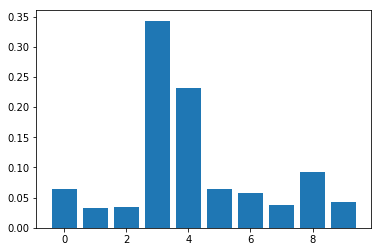

In [79]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load the matrix with topic proportions for each document (note that this excludes those in the dev set).
npz = np.load(os.path.join('output', 'theta.train.npz')) 
ids = npz['ids']
theta = npz['theta']
n_docs, n_topics = theta.shape

index = 1
# plot the proportion of each topic in the first document
fig, ax = plt.subplots()
ax.bar(range(n_topics), theta[index, :])

# find the original line corresponding to this document, and display the text
print(ids[index])
for line in lines:
    doc = json.loads(line)
    if doc['id'] == ids[index]:
        print(doc['text'])
        break


This seems about right! The press release is mostly about returning veterans (topic 3), but also about energy policy (topic 4), with some words from infrastructure mixed in (topic 8).

Now, let's plot the relative prevalance of each topics for each Senator.

Because scholar split the training data into a training set and a dev set, we need to match up the output to the original senator variables.

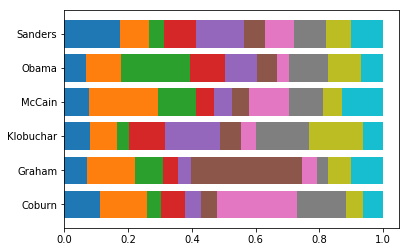

In [80]:

# load the senator variable for all the documents
senators_df = pd.read_csv(os.path.join('tutorial', 'congress', 'train.senator.csv'), header=0, index_col=0)
senators = senators_df.columns

# pull out a subset corresponding to the ids from above
train_subset = senators_df.loc[ids]
n_docs, n_senators = train_subset.shape

# plot the average senator-topic proportions
fig, ax = plt.subplots()
lefts = np.zeros(n_senators)
for k in range(n_topics):
    vals = []
    for senator in senators:
        vals.append(np.mean(theta[train_subset[senator] == 1, k]))

    ax.barh(range(n_senators), vals, left=lefts)
    lefts += np.array(vals)
    
ax.set_yticks(range(n_senators))
ax.set_yticklabels(senators)
plt.show();

This seems to have at least some face validity, with Bernie Sanders writing the most about social issues (topic 0), and Amy Klobuchar writing more about energy/environmental issues (topic 4), but more expertise would be useful in exploring this further. 

## Initializing with pretrained word vectors

Emperically, we found that initializing the model with pretrained word vectors led to greater coherence in the topics. If you are interested in trying this, it is necessary to download the pretrained word2vec vectors from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

Once this is done, and these have been saved somewhere, we can add the `--w2v` option to the model, with a path to the vector file. Here, we'll assume it's in the local directory.

Note that it takes some time to load the word vectors, so we'll just try this once for illustration purposes.

In [45]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator --w2v ./vectors/GoogleNews-vectors-negative300.bin'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator --w2v ./vectors/GoogleNews-vectors-negative300.bin
Loading data
Loaded 2483 documents with 1000 features
Found 2483 non-empty documents
Loading covariates from tutorial/congress/train.senator.csv
Computing background frequencies
Min/max word counts in training data: 89 5075
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1000
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 6
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Loading word vectors
Found embeddings for 991 words
Optimizing full model
Epoch: 10 cost= 1138.788166772
Epoch: 10; Dev perplexity = 840.7113
Epoch: 20 cost= 1070.779092605
Epoch: 20; Dev perplexity = 690.3290
Epoch: 30 cost= 1115.120284317
Epoch: 30; Dev perplexity = 625.7116
Epoch: 40 cost= 1102.541214433
Epoch: 40; Dev perplexity = 591.7534
Epoch: 50 cost= 

In [46]:
beta = np.load('output/beta.npz')['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: iraq statement troops released war win following democratic ; sparsity=0.0000
1: consumer illegal immigration border commission reform products information ; sparsity=0.0000
2: departments grants project fire receive equipment announce funds ; sparsity=0.0000
3: statement press released announced announces browse following lindsey ; sparsity=0.0000
4: energy renewable gas global oil sources vehicles incentives ; sparsity=0.0000
5: court judge supreme justice values decisions chief respect ; sparsity=0.0000
6: assistance affected counties recovery residents dick disaster delegation ; sparsity=0.0000
7: fiscal billion budget tax appropriations spending priorities earmarks ; sparsity=0.0000
8: guard care veterans returning members service health medical ; sparsity=0.0000
9: iraq course back troops forces strategy war illegal ; sparsity=0.0000


In this case, the results seem quite similar, but it might be more beneficial when working with a larger vocabualry (and therefore words which occur less frequently).

## Adding more covariates

Note that we can easily include additional covarites in the same way as we did for senators. Let's try also including covariates for year and month. Just include them in a comma-separated list (again, without spaces).

In [81]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator,year,month'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator,year,month
Loading data
Loaded 2483 documents with 1000 features
Found 2483 non-empty documents
Loading covariates from tutorial/congress/train.senator.csv
Loading covariates from tutorial/congress/train.year.csv
Loading covariates from tutorial/congress/train.month.csv
Computing background frequencies
Min/max word counts in training data: 89 5075
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1000
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 22
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Optimizing full model
Epoch: 10 cost= 1116.675995351
Epoch: 10; Dev perplexity = 882.6570
Epoch: 20 cost= 1078.618546386
Epoch: 20; Dev perplexity = 764.7248
Epoch: 30 cost= 1073.322633748
Epoch: 30; Dev perplexity = 677.8801
Epoch: 40 cost= 1041.660238176
Epoch: 40; Dev perplexity = 6

Now if we load the covariate vectors, we will also see some temporal patterns in word frequencies. The ones here don't seem all that compelling, but perhaps more data is needed.

In [82]:
topic_covars = np.load(os.path.join('output', 'beta_c.npz'))
weights = topic_covars['beta']
names = topic_covars['names']
print_top_words(weights, vocab, topic_names=names, n_pos=8, n_neg=0);

Coburn: citizen coburn per room tom released earmarks transparency ; sparsity=0.0000
Graham: wes releases graham carolina browse hickman kevin lindsey ; sparsity=0.0000
Klobuchar: klobuchar minnesota secured consumer commerce serves beyond guard ; sparsity=0.0000
McCain: mccain browse freedom john record success simply greater ; sparsity=0.0000
Obama: barack release immediate illinois julian obama gibbs contact ; sparsity=0.0000
Sanders: sanders bernie http read sen vermont warming bush ; sparsity=0.0000
2005: julian tommy vietor green robert gibbs announces south ; sparsity=0.0000
2006: tommy vietor gibbs julian robert announce terrorists green ; sparsity=0.0000
2007: labolt ben brundage farmers farm sanders consequences http ; sparsity=0.0000
2008: petitions polls alerts pursuant newsletters ortiz initiated michael ; sparsity=0.0000
Apr: april location price temporary prices drug abuse calls ; sparsity=0.0000
Aug: august transportation announce letter damage receive office area ; spa

## Interactions

Alternatively, we can include interactions between covariates and topics.

Here, let's try using a covariate for party membership, rather than for each Senator, and include interactions between topics and party. To do this, just include the `--interactions` options.

In [83]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 10 --epochs 200 --dev-folds 10 --seed 99 --topic-covars party --interactions'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 10 --epochs 200 --dev-folds 10 --seed 99 --topic-covars party --interactions
Loading data
Loaded 2483 documents with 1000 features
Found 2483 non-empty documents
Loading covariates from tutorial/congress/train.party.csv
Computing background frequencies
Min/max word counts in training data: 89 5075
Network architecture:
embedding_dim: 300
n_topics: 10
vocab_size: 1000
label_type: None
n_labels: 0
n_prior_covars: 0
n_topic_covars: 2
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: True
Optimizing full model
Epoch: 10 cost= 1144.967152982
Epoch: 10; Dev perplexity = 1011.0764
Epoch: 20 cost= 1103.227287822
Epoch: 20; Dev perplexity = 964.6040
Epoch: 30 cost= 1097.839415548
Epoch: 30; Dev perplexity = 814.4726
Epoch: 40 cost= 1063.225387129
Epoch: 40; Dev perplexity = 710.2364
Epoch: 50 cost= 1081.885306339
Epoch: 50; Dev perplexity = 678.7429
Epoch: 60 cost= 1063.214185062
Epoch: 60

First, let's look at the vectors learned for each party, then the topics, then the interactions.

In [84]:
topic_covars = np.load(os.path.join('output', 'beta_c.npz'))
weights = topic_covars['beta']
names = topic_covars['names']
print_top_words(weights, vocab, topic_names=names, n_pos=8, n_neg=0);

D: immediate vietor minnesota labolt damage veterans farmers vermont ; sparsity=0.0000
R: relases hickman departments record current lindsey releases freedom ; sparsity=0.0000


In [85]:
beta = np.load(os.path.join('output', 'beta.npz'))['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: duty insurance active men care members service families ; sparsity=0.0000
1: fire grants awarded tools dick purchase assistance sincerely ; sparsity=0.0000
2: consumers mccain choice hearing market commerce industry consumer ; sparsity=0.0000
3: carolina announces south bishop wes announced investment relases ; sparsity=0.0000
4: earmarks recovery spending coburn dollars room taxpayers congress ; sparsity=0.0000
5: immigration renewable oil fuel energy fuels illegal economy ; sparsity=0.0000
6: projects defense funding construction project million research secured ; sparsity=0.0000
7: statement released nomination following passing julian release alerts ; sparsity=0.0000
8: sanders warming court http change votes things global ; sparsity=0.0000
9: iraq iraqi general violence political strategy security accountability ; sparsity=0.0010


In [86]:
interactions = np.load(os.path.join('output', 'beta_ci.npz'))
weights = interactions['beta']
names = topic_covars['names']
names = [str(k) + ':' + c for k in range(10) for c in names]
print_top_words(weights, vocab, topic_names=names, n_pos=8, n_neg=0);

0:D: served service sanders returning soldiers veterans members insurance ; sparsity=0.0000
0:R: freedom always choice individuals greater control social rates ; sparsity=0.0000
1:D: dick durbin dear request sincerely counties assistance letter ; sparsity=0.0000
1:R: announce fire grants awarded demint equipment announces personnel ; sparsity=0.0000
2:D: klobuchar consumers consumer drug prices industry commerce companies ; sparsity=0.0000
2:R: mccain john choice power browse legislation regarding commitment ; sparsity=0.0000
3:D: bill reform products klobuchar farm consumer safety commission ; sparsity=0.0000
3:R: announces wes kevin bishop hickman carolina demint south ; sparsity=0.0000
4:D: assistance recovery relief income counties quickly local residents ; sparsity=0.0000
4:R: earmarks room coburn spending per bills congress transparency ; sparsity=0.0000
5:D: fuels fuel oil renewable energy economy independence vehicles ; sparsity=0.0000
5:R: immigration border illegal reform sec

The basic topics here are now perhaps less good, but the interaction do seem to capture something about how the different parties talk about certain issues. For example, for topic 0 (veterans), The democratic version emphasizes serice, and membership, whereas the republican versionis more about freedom and choice. More data (from all the senators) would give us a much better approxaimation of this.

## Adding labels

In addition to covariates, we can also introduce labels, which are predicted from the topics that are learned. Although they only introduce a subtle influence on the topic, we are effectively learning a classifier and a topic model simultaneously.

Here, let's try predicting the party of a press release from the topics. We'll also try using more topics

In [87]:
script = 'run_scholar.py'
args = 'tutorial/congress/ -k 15 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator,month --label party'
print("python", script, args)
run_scholar.main(args.split())

python run_scholar.py tutorial/congress/ -k 15 --epochs 150 --dev-folds 10 --seed 99 --topic-covars senator,month --label party
Loading data
Loaded 2483 documents with 1000 features
Found 2483 non-empty documents
Loading labels from tutorial/congress/train.party.csv
Found 2 labels
Loading covariates from tutorial/congress/train.senator.csv
Loading covariates from tutorial/congress/train.month.csv
Train label proportions: [0.54007249 0.45992751]
Computing background frequencies
Min/max word counts in training data: 89 5075
Network architecture:
embedding_dim: 300
n_topics: 15
vocab_size: 1000
label_type: None
n_labels: 2
n_prior_covars: 0
n_topic_covars: 18
l1_beta_reg: 0.0
l1_beta_c_reg: 0.0
l1_beta_ci_reg: 0.0
l2_prior_reg: 0.0
classifier_layers: 1
use_interactions: False
Optimizing full model
Epoch: 10 ; cost = 1124.008647057 ; training accuracy (noisy) = 0.551677852
Epoch: 10; Dev perplexity = 1061.4584; Dev accuracy = 0.6976
Epoch: 20 ; cost = 1080.446302171 ; training accuracy (no

First let's look at the topics as usual

In [88]:
beta = np.load(os.path.join('output', 'beta.npz'))['beta']
print_top_words(beta, vocab, n_pos=8, n_neg=0);

0: court supreme judge nomination legal justice position chief ; sparsity=0.0000
1: announces medical awarded announced care quality grant health ; sparsity=0.0000
2: veterans defense authorization affairs military armed members benefits ; sparsity=0.0000
3: insurance americans tell care class children let parents ; sparsity=0.0000
4: iraq troops political war course success iraqi forces ; sparsity=0.0000
5: soldiers returning afghanistan sacrifice military men guard armed ; sparsity=0.0000
6: tax financial taxpayers income taxpayer housing costs paying ; sparsity=0.0000
7: releases browse bishop announces relases record lindsey announced ; sparsity=0.0000
8: durbin dick assistance residents letter request dear sincerely ; sparsity=0.0010
9: projects project funding infrastructure appropriations million river transportation ; sparsity=0.0000
10: commission criminal homeland conduct legal security election travel ; sparsity=0.0000
11: immigration reform illegal oil border gas trade pric

Now let's look at which topics predict Democrat vs Republican.

In [89]:
npz = np.load('output/topics_to_labels.npz')
probs = npz['probs']
label_names = npz['label']
n_topics, n_labels = probs.shape
print("Labels:", ' '.join([name for name in label_names]))
for k in range(n_topics):
    output = str(k) + ': '
    for i in range(n_labels):
        output += '%.4f ' % probs[k, i]
    print(output)


Labels: D R
0: 0.1696 0.8304 
1: 0.1392 0.8608 
2: 0.6234 0.3766 
3: 0.8487 0.1513 
4: 0.4693 0.5307 
5: 0.8374 0.1626 
6: 0.6764 0.3236 
7: 0.0032 0.9968 
8: 0.9229 0.0771 
9: 0.4275 0.5725 
10: 0.6437 0.3563 
11: 0.2332 0.7668 
12: 0.3234 0.6766 
13: 0.9301 0.0699 
14: 0.9944 0.0056 


These numbers show the probability (according to the model) that a document entirely about a single topic is from a Democrat vs a Republican. Of course, in practice, most documents will be represented as a mixture of topics, and both parties talk about all topics to some degree.

Some of these associations seem to be possibly over-fitting to certain stylistic differences (e.g. topics 14 and 7), but others do seem to be capturing party priorities, such as the supreme court, immigration, and the environment. Again more data from more Senators would help here.

Ultimately, exploration of different models is requried to figure out what is best for your application. Also, remember than trying a different random seed will give you different results.